In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [3]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position = 1 / fcen
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + 1/fcen
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [4]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [5]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [6]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    return x

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


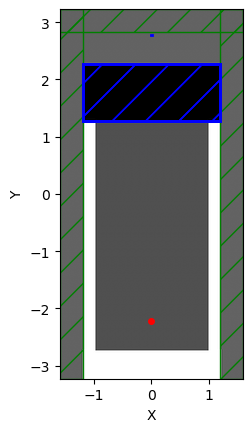

In [7]:
monitor_position, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

opt.plot2D(True)

In [8]:
evaluation_history = []
cur_iter = [0]
numevl = 1

def f(v, gradient, beta):
    global numevl
    print("Current iteration : {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.real(dJ_du).ravel()
        )  # backprop

    evaluation_history.append([np.max(np.real(f0))])
    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FOM : {}".format(evaluation_history))
    print("Current f0 value: {}".format(np.real(f0)))

    return np.mean(f0)

In [90]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 8
update_factor = 10
ftol = 1e-5
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration : 21
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 2.5034e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0604949 s
time for se

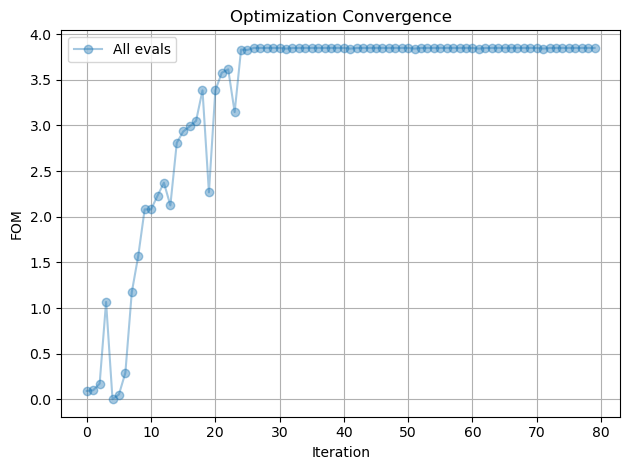

In [184]:
plt.plot(evaluation_history[20:], 'o-',   label='All evals', alpha=0.4)
# plt.plot(best_history,       's--', label='Best-so-far')
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.title('Optimization Convergence')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# np.savetxt("Freeform_1.txt", design_variables.weights)

In [9]:
import numpy as np

data = np.loadtxt('Freeform_1.txt')

print("Loaded array shape:", data.shape)

opt.update_design([data])


Loaded array shape: (6171,)


     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


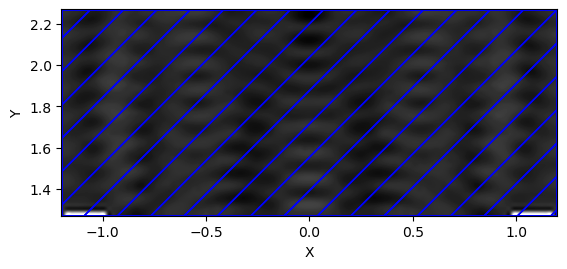

In [10]:
opt.plot2D(
    True,
    output_plane = mp.Volume(size = design_region.size, center = design_region.center),
    
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

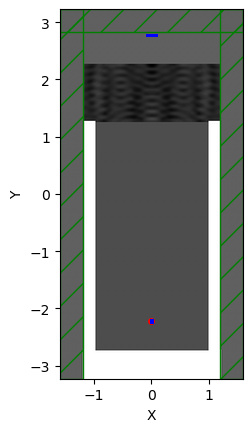

In [46]:
opt.update_design([data])

offset = 0.01
flux_size = 0.02
mn_size = 0.3*1/fcen
# mn_size = 2
monitor_position_y, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(mn_size,0,0)

#### input source의 flux ####
input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

#### output flux -> add flux로 계산한 poynting vector ####
out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
                center=monitor_position_y,
                size=monitor_size,
                # direction=mp.Y
        )
    )

#### output flux -> 성분별 field를 뽑고, poynting vector를 계산할 예정 ####
dft_fields = opt.sim.add_dft_fields([mp.Ex, mp.Ey, mp.Ez, mp.Hx, mp.Hy, mp.Hz], fcen, 0, 1, 
                                    center = monitor_position_y,
                                    size = monitor_size, 
                                    yee_grid=True)

opt.sim.plot2D()

-----------
Initializing structure...
time for choose_chunkdivision = 4.3869e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0557971 s
time for set_conductivity = 0.0020988 s
time for set_condu

<Axes: xlabel='X', ylabel='Y'>

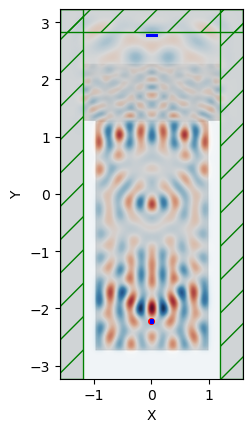

In [47]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))
opt.sim.plot2D(fields = mp.Ez)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


<Axes: xlabel='X', ylabel='Y'>

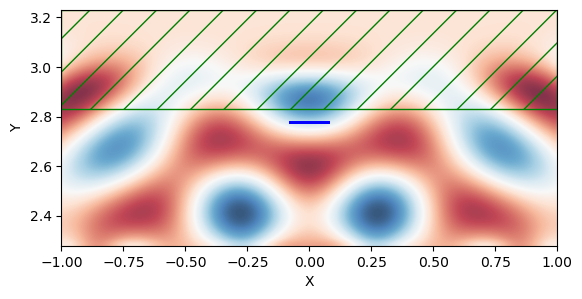

In [48]:
opt.sim.plot2D(fields = mp.Ez, output_plane=mp.Volume(
    center = monitor_position_y,
    size = mp.Vector3(2, 1)
))

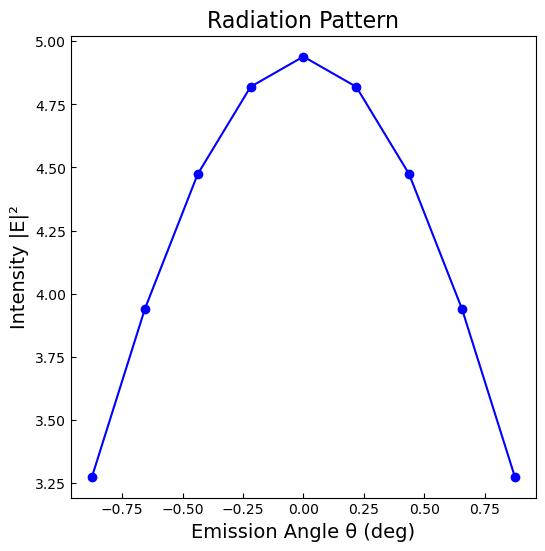

In [49]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = mn_size                           # μm 단위 모니터 폭
x = np.linspace(-W/2, W/2, N)                     # μm 단위 위치
z = abs(center_y_monitor_position - center_y_source_position)  # μm 단위 거리
theta = np.degrees(np.arctan2(x, z))               # rad → deg 변환

# 3) Intensity 계산
I = np.abs(external_field_array)**2

# 4) θ 축으로 플롯
plt.figure(figsize=(6,6))
plt.plot(theta, I, 'bo-')
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.ylabel('Intensity |E|²',       fontsize=14)
plt.title('Radiation Pattern',     fontsize=16)
plt.tick_params(direction = 'in')
plt.show()

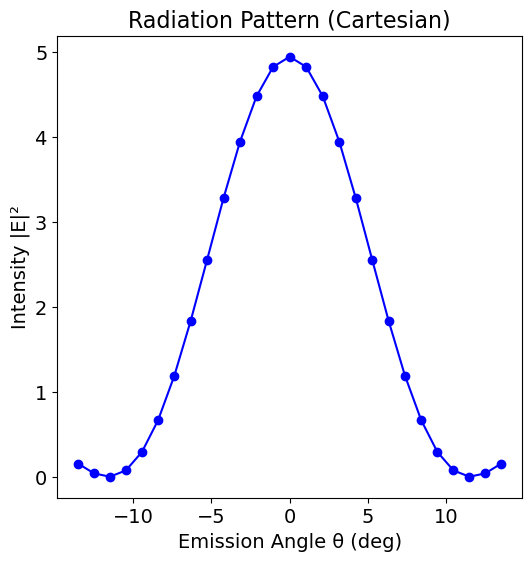

In [ ]:
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)

N = len(external_field_array)
W = design_region_width

x = np.linspace(-W/2, W/2, N)
z = abs(center_y_monitor_position - center_y_source_position)

theta = np.arctan2(x, z)
theta_deg = np.degrees(theta)

plt.figure(figsize = (6,6))
plt.title('Radiation Pattern (Cartesian)', fontsize=16)

plt.plot(theta_deg, np.abs(external_field_array)**2, 'bo-')
plt.ylabel('Intensity |E|²', fontsize=14)
plt.xlabel('Emission Angle θ (deg)', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

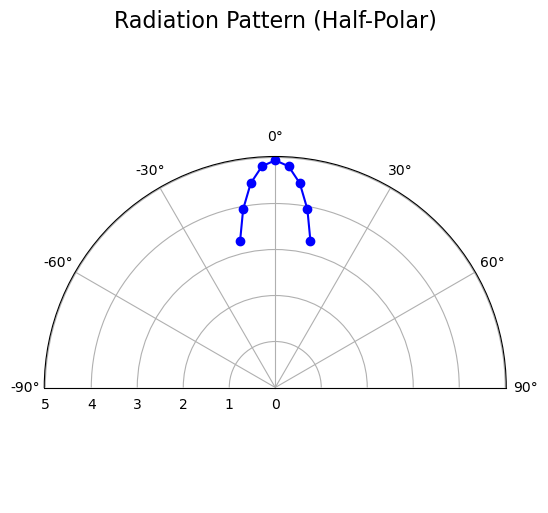

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# 1) 데이터 준비 (기존과 동일)
external_field_array = opt.sim.get_dft_array(dft_fields, mp.Ez, 0)
N  = len(external_field_array)
W  = design_region_width
x  = np.linspace(-W/2, W/2, N)
z  = abs(center_y_monitor_position - center_y_source_position)
theta = np.arctan2(x, z)         # radian
I     = np.abs(external_field_array)**2

# 2) polar 플롯
fig = plt.figure(figsize=(6,6))
ax  = fig.add_subplot(111, projection='polar')

# θ=0을 위쪽(North)로, 시계 반대방향을 +로 설정
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# 반원만 보이도록 θ 범위 제한 (-π/2 ~ +π/2)
ax.set_thetalim(-np.pi/2, np.pi/2)

# 방사 패턴 그리기 (r=I, θ=theta)
ax.plot(theta, I, 'ob-')

# 레이블
ax.set_title('Radiation Pattern (Half-Polar)', va='bottom', fontsize=16)
ax.set_rlabel_position(135)  # radial tick 라벨 위치
# ax.set_xlabel('Emission Angle θ')  # polar 축 위에만 보이므로 선택적

plt.show()


In [17]:
# 1) 계산할 주파수 인덱스 (예: 첫 번째 주파수)
freq_idx = 0

# 2) DFT 모니터에서 Ez, Hx 스펙트럼 배열(복소수) 꺼내기
Ez_hat = sim.get_dft_array(dft_fields, mp.Ez, freq_idx)  # shape = (N,)
Hx_hat = sim.get_dft_array(dft_fields, mp.Hx, freq_idx)  # shape = (N,)

# 3) y-방향 Poynting 밀도 계산

Sy_density = np.real(Ez_hat * np.conj(Hx_hat))   

# 4) 모니터 축 방향 좌표 생성
L = float(monitor_size.x)      # 실제 모니터 길이 (mn_size)
N = Sy_density.size            # 샘플 포인트 개수
# x 좌표를 -L/2 ~ +L/2 로 균등 분포시킴
x = np.linspace(-L/2, L/2, N)  

# 5) 트라페zo이달(rule) 적분으로 전체 플럭스 계산
flux_total = np.trapz(Sy_density, x)  
add_flx = np.array(mp.get_fluxes(out_flux))[0]

# 6) 결과 출력
print(f"DFT monitor 적분으로 구한 total flux = {flux_total}")
print("Add flux로 계산한 total flux = ", add_flx)

err = np.abs((flux_total-add_flx)/add_flx)*100
print("오차율 (%) : ", err, "%")

DFT monitor 적분으로 구한 total flux = 0.7869043991358097
Add flux로 계산한 total flux =  0.8010771464047926
오차율 (%) :  1.7692112841553018 %


In [18]:
print("Output flux :", flux_total)
print("Input flux :", np.array(mp.get_fluxes(input_flux))[0])
print("EQE(%) :", flux_total / np.array(mp.get_fluxes(input_flux))[0] * 100, "%")

Output flux : 0.7869043991358097
Input flux : 0.8702110270794768
EQE(%) : 90.42684758623972 %


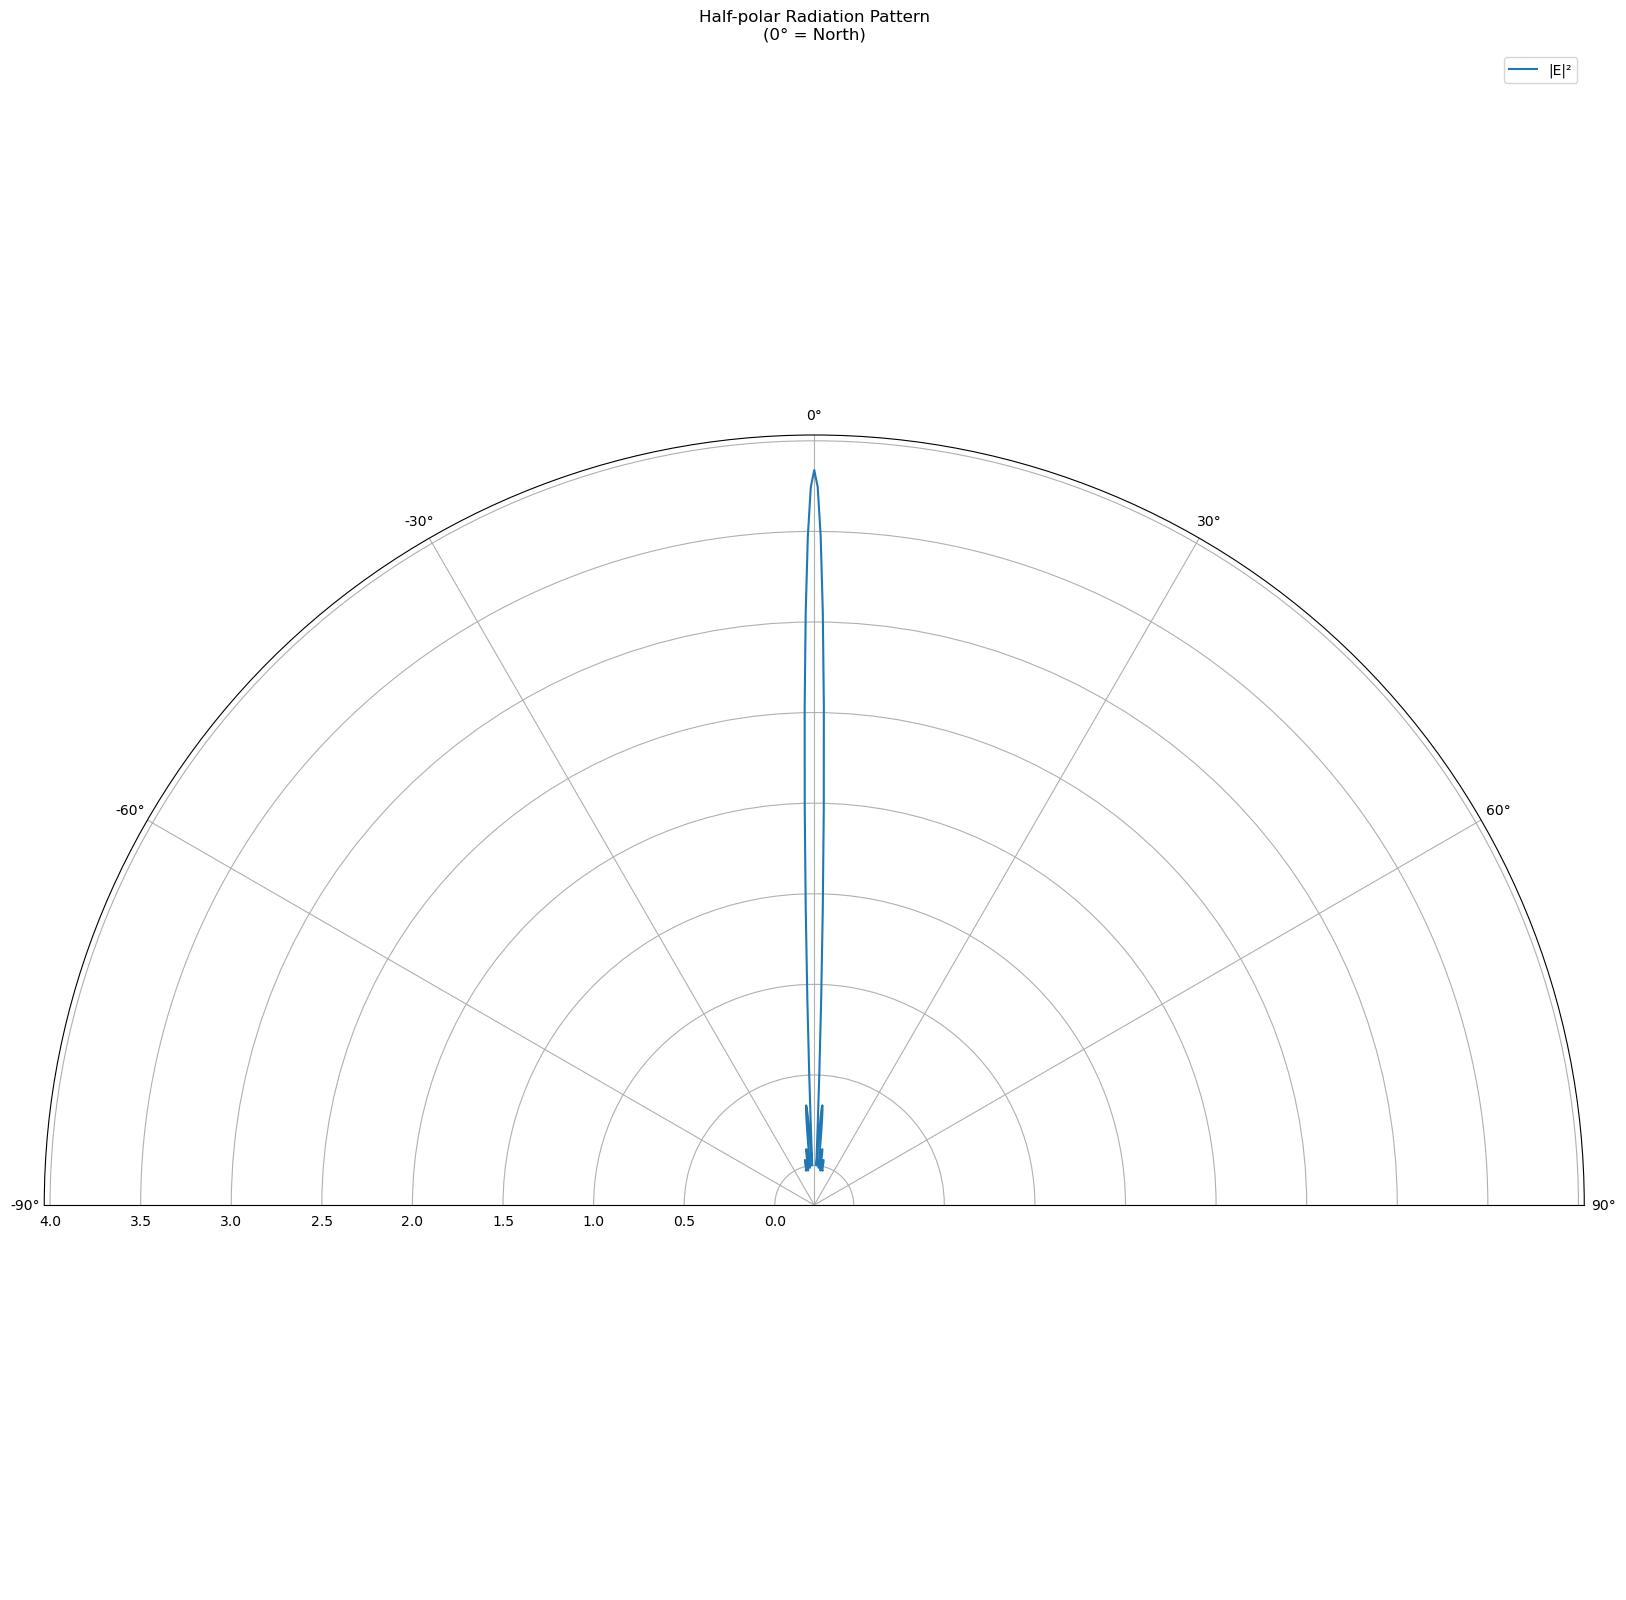

In [181]:
import numpy as np
import matplotlib.pyplot as plt

# 1) external_flux, x 좌표 계산 (기존 코드)
external_flux = sim.get_dft_array(dft_fields, mp.Ez, freq_idx)
N = len(external_flux)
W = design_region_width
x = np.linspace(-W/2, W/2, N)
I = external_flux**2  # intensity

# 2) 모니터와 소스 사이 수직거리 z (μm 단위)
z = abs(center_y_monitor_position - center_y_source_position)

# 3) x → emission angle θ 변환 (rad)
#    θ = arctan(x/z) 이면 0일 때 북쪽(수직상방), ±90°까지
theta = np.arctan2(x, z)  

# 4) 반원(±90°) 범위만 남기기
mask = (theta >= -np.pi/2) & (theta <= np.pi/2)
theta = theta[mask]
I     = I

# 5) polar 플롯
fig = plt.figure(figsize=(20,20))
ax  = fig.add_subplot(111, projection='polar')
ax.set_theta_zero_location('N')   # 0도를 위쪽으로
ax.set_theta_direction(-1)        # CW 방향으로 증가

ax.plot(theta, I, '-', label='|E|²')
ax.set_thetamin(-90)              # −90° ~ +90° 만 보여줌
ax.set_thetamax(90)
ax.set_rlabel_position(135)       # radial tick 라벨 위치
ax.set_title('Half-polar Radiation Pattern\n(0° = North)', va='bottom')
ax.legend(loc='upper right')
plt.show()
